# Deep Learning project
Intro by Tatiana

In [46]:
# Libraries
# Colab libraries
from google.colab import drive
from google.colab import output
drive.mount('/content/gdrive')
colab_path = "/content/gdrive/My Drive/Colab Notebooks/"

# Basis libraries
import os, re, sys, math, time, scipy, argparse
import cv2, matplotlib
import matplotlib.gridspec as gridspec
import numpy as np
import pylab as plt
from ipywidgets import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage.filters import gaussian_filter, maximum_filter

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Section 0: Download and install repository
First, we will download the repository that we copied from the [original repository](https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation) in order to make some changes for educational purposes. Then, we install libraries and some dependences explained in the original repository.

In [2]:
# Independence install
!sudo apt-get install swig
%cd $colab_path
if not os.path.isdir("RT-multiperson-pose-pytorch"):
  # Repository clone
  !git clone https://github.com/Johansmm/RT-multiperson-pose-pytorch.git
  %cd "RT-multiperson-pose-pytorch"
  %cd lib/pafprocess 
  # Repository compile
  !sh make.sh

# Libraries install
%cd $colab_path"/RT-multiperson-pose-pytorch"
!python -m pip install -r ./requirements.txt
!git submodule init && git submodule update
# Weights download
if not os.path.isfile("./pose_model.pth"):
  !wget https://www.dropbox.com/s/ae071mfm2qoyc8v/pose_model.pth
output.clear()
print("[INFO]: Proyect uploaded successfully")

[INFO]: Proyect uploaded successfully


In [3]:
!python demo/picture_demo.py

Bulding VGG19
Done !
0.5459940652818991


In [4]:
# Framework libraries
%cd $colab_path"/RT-multiperson-pose-pytorch"
sys.path.append('.')
from lib.network.rtpose_vgg import get_model
from lib.network import im_transform
from lib.utils.common import Human, BodyPart, CocoPart, CocoColors, CocoPairsRender, draw_humans
from lib.utils.paf_to_pose import paf_to_pose_cpp
from lib.config import cfg, update_config
from evaluate.coco_eval import get_outputs, handle_paf_and_heat, run_eval

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch


## Section 2: Replication of results
In this section we replicated some resutls. First, we need download the data. For this case, we will use the `sh` compiler provided by [original repository](https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation)

In [5]:
%cd $colab_path"/RT-multiperson-pose-pytorch"
data_download = False # For download COCO dataset
if data_download and not os.path.isdir("data/coco"):
  !mkdir data
  %cd data
  !sh ../lib/datasets/CocoDataDownloader.sh
  %cd $colab_path"/RT-multiperson-pose-pytorch"
  output.clear()
  print("[INFO]: Coco database downloaded successfully")

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch


Now, we defined some principal functions and the neuronal network architecture.



In [6]:
%cd $colab_path"/RT-multiperson-pose-pytorch"
class Namespace:
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

def load_rtpose_model():
  args = Namespace(cfg = './experiments/vgg19_368x368_sgd.yaml', weight = 'pose_model.pth', opts = [])
  update_config(cfg, args)
  model = get_model('vgg19')     
  model.load_state_dict(torch.load(args.weight))
  model = torch.nn.DataParallel(model).cuda()
  model.float()
  model.eval()
  return model

def im_forward(image, model):
  with torch.no_grad():
    paf, heatmap, im_scale = get_outputs(image, model, 'rtpose')
  return paf, heatmap, im_scale

def human_forward(image, model):
  paf, heatmap, im_scale = im_forward(image, model)
  humans = paf_to_pose_cpp(heatmap, paf, cfg)
  return draw_humans(image, humans), humans

rtpose_model = load_rtpose_model()

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch
Bulding VGG19
Done !


In order to display some results, images will be chosen at random to reproduce the paper's results. A grid will be created with some samples.

[INFO]: Images through RT-multiperson pose 2D:


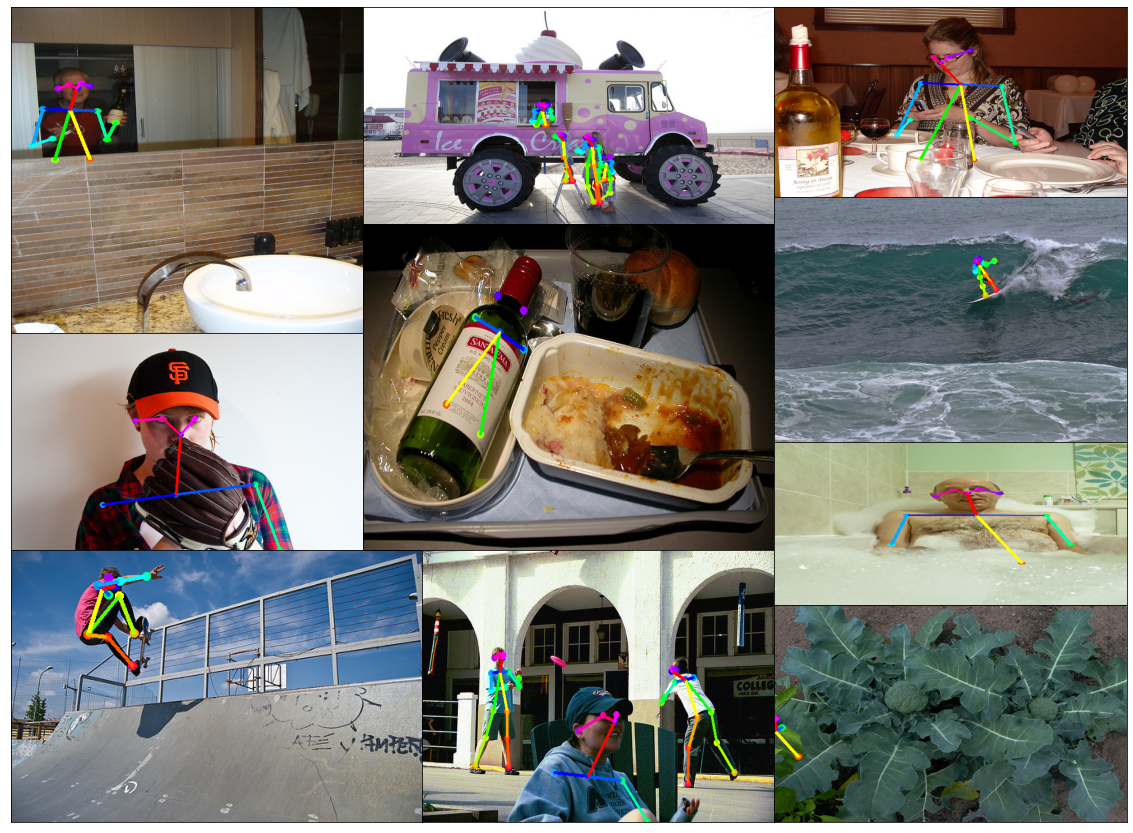

In [10]:
def readFileList(file_directory, ext = 'jpg'):
    files_list = []
    if os.path.isdir(file_directory): # Return files with 'json' extension
        for root_path, _, files_name in os.walk(file_directory):
            files_list += [os.path.join(root_path, element) for element in files_name if element.split(".")[-1].lower() == ext.lower()]
    elif file_directory.split('.')[-1] == ext: files_list = [file_directory] # Return file inside of list
    return files_list

file_list = readFileList("./data/coco/images/test2017")
if len(file_list) > 0:
    print("[INFO]: Images through RT-multiperson pose 2D:")
    fig = plt.figure(figsize=(20, 15), constrained_layout=False)
    gs = fig.add_gridspec(nrows=30, ncols=19, wspace=0.0, hspace=0.0)
    fig_axes = {
        fig.add_subplot(gs[:12, :6]): {"id": "image1_1"}, # First column
        fig.add_subplot(gs[12:20, :6]): {"id": "image2_1"},
        fig.add_subplot(gs[20:, :7]): {"id": "image3_1"},
        fig.add_subplot(gs[:8, 6:13]): {"id": "image1_2"}, # Second column
        fig.add_subplot(gs[8:20, 6:13]): {"id": "image2_2"},
        fig.add_subplot(gs[20:, 7:13]): {"id": "image3_2"},
        fig.add_subplot(gs[:7, 13:]): {"id": "image7"}, # Third column
        fig.add_subplot(gs[7:16, 13:]): {"id": "image8"},
        fig.add_subplot(gs[16:22, 13:]): {"id": "image9"},
        fig.add_subplot(gs[22:, 13:]): {"id": "image10"},
    }

    for ax, prop in fig_axes.items():
        human_det = []
        while len(human_det) == 0:
            image = cv2.imread(np.random.choice(file_list))
            image_rt, human_det = human_forward(image, rtpose_model)
        ax.imshow(cv2.cvtColor(image_rt, cv2.COLOR_BGR2RGB), aspect = "auto")
        ax.set_xticklabels([]); ax.set_yticklabels([])
        ax.set_xticks([]); ax.set_yticks([]); ax.axis("on")
    fig.show()
else:
    print("[INFO]: Not image found. Please check image folder")

In [11]:
isrun = False
try:
    if isrun:
        run_eval(image_dir= './data/coco/images/val2017', 
          anno_file = './data/coco/annotations/annotations/person_keypoints_val2017.json', 
          vis_dir = './data/coco/images/vis_val2017', model=model, preprocess='vgg')
except:
    pass

The summary of the evaluation statistics are presented below. For the validation set, we can see that the model is recognizing about 13% of the cases correctly, of which we can be sure that about 20% are being well detected.

<table>
<tbody>
  <tr>
    <th>Average Precision (AP)</th> <th>IoU=0.50:0.95</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.091</th>
  </tr>
  <tr>
    <th>Average Precision (AP)</th> <th>IoU=0.50</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.223</th>
  </tr>
  <tr>
    <th>Average Precision (AP)</th> <th>IoU=0.75</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.057</th>
  </tr>
  <tr>
    <th>Average Precision (AP)</th> <th>IoU=0.50:0.95</th> <th>area = medium</th> <th>maxDets = 20</th> <th>0.131</th>
  </tr>
  <tr>
    <th>Average Precision (AP)</th> <th>IoU=0.50:0.95</th> <th>area = large</th> <th>maxDets = 20</th> <th>0.091</th>
  </tr>
  <tr>
    <th>Average Recall (AR)</th> <th>IoU=0.50:0.95</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.188</th>
  </tr>
  <tr>
    <th>Average Recall (AR)</th> <th>IoU=0.50</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.350</th>
  </tr>
  <tr>
    <th>Average Recall (AR)</th> <th>IoU=0.75</th> <th>area = all</th> <th>maxDets = 20</th> <th>0.167</th>
  </tr>
  <tr>
    <th>Average Recall (AR)</th> <th>IoU=0.50:0.95</th> <th>area = medium</th> <th>maxDets = 20</th> <th>0.140</th>
  </tr>
  <tr>
    <th>Average Recall (AR)</th> <th>IoU=0.50:0.95</th> <th>area = large</th> <th>maxDets = 20</th> <th>0.255</th>
  </tr>
</tbody>
</table>

## Section 3: Applications
Some applications in the field of deep learning have been developed in recent years with themes relating to the detection of the position of people in different scenes. Some of these include the classification of postures, detection of people in position, robots assisted living, character animation, video games industry, medical applications such as postural corrections, and anothers [interesting projects](https://medium.com/beyondminds/an-overview-of-human-pose-estimation-with-deep-learning-d49eb656739b). Below are some articles of interest:

1.   [Multi-Person Pose Estimation for Pose Tracking with Enhanced Cascaded Pyramid Network](https://openaccess.thecvf.com/content_ECCVW_2018/papers/11130/Yu_Multi-Person_Pose_Estimation_for_Pose_Tracking_with_Enhanced_Cascaded_Pyramid_ECCVW_2018_paper.pdf)
2.   [Single-Stage Multi-Person Pose Machines](https://arxiv.org/pdf/1908.09220.pdf)
3.   [Rehabilitation Posture Correction Using Deep Neural
Network](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7881743)
4.   [Pose Trainer: Correcting Exercise Posture using Pose Estimation](https://arxiv.org/abs/2006.11718)



In this notebook, we will attack in a particular aplication: The detection of multiple person poses in videos and their prediction in later frames.

### Implementation of architecture in videos
Let's start with the implementation of the architecture in a test video. We will make the frame to frame reading, showing the result of the estimation. [database](https://www.robots.ox.ac.uk/~vgg/data/tv_human_interactions/)

In [71]:
''' Extract properties from video '''
def video_prop_read(video_path, force_mp4 = True):
    video = cv2.VideoCapture(video_path) # Read video
    w,h = int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_fps = video.get(cv2.CAP_PROP_FPS)
    codec = [chr((int(video.get(cv2.CAP_PROP_FOURCC)) >> 8 * i) & 0xFF) for i in range(4)]
    video_size = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    video.release()
    if "mp4" in os.path.splitext(video_path)[-1].lower() or force_mp4: codec = ['m', 'p', '4', 'v']
    if video_size <= 0: video_size = np.inf
    if video_fps <= 0 or video_fps == np.inf: video_fps = 25 # Default value
    return w, h, video_fps, codec, video_size

''' Show embed video'''
def show_video(video_path):
    filename, ext = os.path.splitext(video_path)
    if os.path.isfile(video_path):
        if "mp4" not in ext.lower():
            filename += ".mp4"
            !sudo ffmpeg -t 5 -i "$video_path" "$filename" # Convert any ext to mp4
            output.clear()
            video_path = filename
        video = Video.from_file("./data/videos/demo.mp4")
    else:
        print("[ERROR] Video file not found. Please check path.")
        video = None
    return video

''' Draw humans in video '''
def video_boxes(video_in, fps = None, video_out_path = None, force_mp4 = True):
    # Read video properties
    video_w, video_h, video_fps, video_codec, video_size = video_prop_read(video_in, force_mp4)
    video = cv2.VideoCapture(video_in)

    # Video object to save and video_in read
    if fps is not None and fps < video_fps: video_fps = fps
    if video_out_path is not None:
        video_out_path, ext = os.path.splitext(video_out_path)
        if force_mp4: video_out_path += ".mp4"
        elif len(ext) == 0: video_out_path += os.path.splitext(video_in)[-1]
        else: video_out_path += ext
        
        video_out = cv2.VideoWriter(video_out_path, cv2.VideoWriter_fourcc(*video_codec), video_fps, (video_w, video_h))
        print("[INFO]: Video will be saved in", video_out_path)

    fcount = 0; tic = time.time()
    while video.isOpened():
        ret, frame = video.read(); fcount += 1
        if fps is not None and fcount % (fps//video_fps) != 0: continue # Skip frames
        if (cv2.waitKey(1) & 0xFF == ord('q')) or not ret: break # End of video

        # Detection process
        paf, heatmap, im_scale = im_forward(frame, rtpose_model) # CNN maps
        if "total_paf" not in locals():
            total_paf, total_heatmap = [paf], [heatmap]
        else:
            total_paf += [paf]; total_heatmap += [heatmap]
        humans = paf_to_pose_cpp(heatmap, paf, cfg)

        # Save pose-detection in video_out
        if video_out_path is not None:
            frame_out = draw_humans(frame, humans)
            video_out.write(frame)
        
        # if isprogrammer: cv2.imshow("output.mp4", frame)
        if fcount % 30 == 0:
            print("[INFO]: {} of {} frames processed.".format(fcount, video_size))
        
    video.release()
    if video_out_path is not None: 
        video_out.release()
        if "mp4" in os.path.splitext(video_out_path)[-1]:
            video_out_path_compress = video_out_path.replace(".mp4","_out.mp4")
            !sudo ffmpeg -t 5 -i "$video_out_path" "$video_out_path_compress" # Compress
            !mv "$video_out_path_compress" "$video_out_path"
            !rm "$video_out_path_compress"
            output.clear()
        print("[INFO]: Video saved successfully")
    print("[INFO]: Total time spend in procedure:", time.time() - tic, "s")

In [72]:
video_path_proof = "./data/videos/handShake_0009.avi"
video_boxes(video_path_proof, video_out_path = "./data/videos/demo")

[INFO]: Video saved successfully
[INFO]: Total time spend in procedure: 28.49661636352539 s


In [73]:
show_video("./data/videos/demo.mp4")

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08K#mdat\x00\x00\…

## ***Anexos: GitHub connection***
Here, some functions to upload the github respository

In [ ]:
''' Function definitions'''
# Git pull
def git_pull(repo_pwd, show_current_branch = False, make_commit = False): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        # !git config --list
        if show_current_branch: 
            !git branch 
        if make_commit:
            if "user_git" not in globals(): user_git = input("User github?: ")
            if "email_git" not in globals(): email_git = input("Email github?: ") 
            !git config --global user.email $email_git
            !git config --global user.name $user_git
            !git commit -am "Updating in colab"
        !git pull
        !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

# Git push
def git_push(repo_pwd): # Only for colab space work
    global user_git, email_git
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        import getpass
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        if "user_git" not in globals(): user_git = input("User github?: ")
        if "email_git" not in globals(): email_git = input("Email github?: ")

        # Password login
        try: 
            pwd_git = getpass.getpass(prompt='{} github password: '.format(user_git)) 
        except Exception as error: 
            print('ERROR', error) 

        # Upload from every where
        origin_git = !git config --get remote.origin.url
        origin_git = origin_git[0].replace("https://","https://{}:{}@".format(user_git,pwd_git))

        !git config --global user.email "$email_git"
        !git config --global user.name "$user_git"
        !git status

        x = " "
        while x.lower() != "y" and x.lower() != "n": x = input("Continue?...[y/n]: ")

        if x.lower() == "y":
            com_message = input("Enter the commit message: ")
            !git add .
            !git commit -am $com_message
            !git push $origin
            !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

In [ ]:
repo_pwd = "/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch"
# git_pull(repo_pwd, show_current_branch = False, make_commit = True)
# git_push(repo_pwd)